In [65]:
import pandas as pd
import seaborn as sn
import torch
import time
from torch import nn, optim
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix

import torch.nn.functional as F

from confusion import cm

In [66]:
class PathwayScores(Dataset):

    def __init__(self, csv_file):
        """Initializes instance of class PathwayScores.

        Args:
            csv_file (str): Path to the csv file with the data.

        """
        self.df = pd.read_csv(csv_file, sep='\t')
        self.df = self.df[self.df["PAM50"] != "NC"]

        # Grouping variable namesdict( enumerate(train['PAM50'].cat.categories ) ) 
        self.features = ['Cell_Cycle', 'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53', 'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2']
        self.target = "PAM50"
        
        self.df['PAM50'] = self.df['PAM50'].astype('category')
        self.df['PAM50'] = self.df['PAM50'].cat.codes.values

        # Save target and predictors
        self.X = self.df.loc[:, self.features].values
        self.y = self.df.loc[:, self.target].values

        self.transform = transforms.Compose([transforms.ToTensor()]) 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.transform(self.X.iloc[idx].values), self.transform(self.y[idx])]


In [67]:
class Net(nn.Module):

  def __init__(self, n_features):

    super(Net, self).__init__()

    self.hidden = nn.Linear(n_features, 10)

    self.predict = nn.Linear(10, 1)

  def forward(self, x):

    x = F.relu(self.hidden(x))      # activation function for hidden layer

    x = self.predict(x)             # linear outputç
    
    return x


In [88]:
train = "data/generated/train_augmented.csv"
test = "data/generated/test.csv"
train = pd.read_csv(train)
test = pd.read_csv(test)

In [94]:
X_train = train[['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2','PROLIF','grade','stage']]
y_train = train["RFS"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=47)

In [96]:
X_train = X_train.to_numpy(dtype=float)
y_train = y_train.to_numpy(dtype=int)
X_test = X_test.to_numpy(dtype=float)
y_test = y_test.to_numpy()

In [97]:
len(X_train)

2244

In [98]:
def batch_generator(idata, target, batch_size, shuffle=True):
    nsamples = len(idata)
    if shuffle:
        perm = np.random.permutation(nsamples)
    else:
        perm = range(nsamples)

    for i in range(0, nsamples, batch_size):
        batch_idx = perm[i:i+batch_size]
        if target is not None:
            yield idata[batch_idx], target[batch_idx]
        else:
            yield idata[batch_idx], None

In [102]:
def train(model, criterion, optimizer, X_data, y_data, batch_size, log=False):
    model.train()
    total_loss = 0
    total_acc = 0
    ncorrect = 0
    niterations = 0
    conf = [[0] * 4] * 4 

    for X, y in batch_generator(X_data, y_data, batch_size, shuffle=True):
        
        # Get input and target sequences from batch
        X_train = torch.FloatTensor(X)
        y_train = torch.IntTensor(y)
        print(y_train)
        y_pred = model(X_train)
        print(y_pred)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(y_pred, 1)[1] == y_train).sum().item()
        #print(str((torch.max(y_pred, 1)[1] == y_train).sum().item()) +"/"+str(len(X_train)))
        niterations += 1
    
    #print(str(ncorrect) + "/" + str(len(X_data)) + "=" + str(ncorrect/len(X_data)))
    total_acc = ncorrect/len(X_data)*100

    return total_loss, total_acc

In [105]:
def val(model, criterion, optimizer, X_data, y_data, batch_size, log=False):
    model.eval()
    total_loss = 0
    total_acc = 0
    ncorrect = 0
    niterations = 0
    conf = [[0] * 4] * 4

    with torch.no_grad():
    
        X_val = torch.FloatTensor(X_data)
        y_val = torch.FloatTensor(y_data)

        y_pred = model(X_val)

        ncorrect = (torch.max(y_pred, 1)[1] == y_val).sum().item()
            
    #print(str(ncorrect) + "/" + str(len(X_data)) + "=" + str(ncorrect/len(X_data)))
    total_acc = ncorrect/len(X_data)*100

    return total_acc

In [106]:
model = Net(X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
criterion = torch.nn.MSELoss() 

# Training
t0 = time.time()
epochs = 80
loss_ = []
for epoch in range(1, epochs + 1):
    loss, t_acc= train(model, criterion, optimizer, X_train, y_train, batch_size=200)
    v_acc= val(model, criterion, optimizer, X_test, y_test, batch_size=200)
    loss_.append(loss)
    print(f'| epoch {epoch:03d} | loss={loss:.3f}')
    print(f'    - Training accuracy   = {t_acc:.3f}%')
    print(f'    - Validation accuracy = {v_acc:.3f}% \n')

tensor([ 854,  712,  459,  764, 5114, 1092, 1099, 3574,  152, 1790, 1484, 3198,
         912, 4134, 1293, 1662,  939, 1447, 5245, 2018, 6130, 2693, 1569, 2166,
        4554, 2287, 2964, 3743, 6660, 5222, 3859, 4482,  432, 2016, 1941, 5090,
        5460,  803, 1277, 4535, 5216, 3623, 1880, 2951,  356, 5966,   49, 4096,
        1573, 2673, 1718, 3556, 1339, 4897, 3736, 4364, 1643, 4633, 4241, 5656,
        4466, 2107, 2767, 4157, 4437, 1403, 2404, 3478,  257,  283, 2561,  810,
         750, 2617, 4136, 2745, 1772, 5549, 3347, 1181, 5949, 3736, 2018,  466,
        1589, 2330, 3921, 1885, 2577, 2019, 4152, 1391, 1500, 2647, 2577, 5724,
        3724, 4290, 4188, 2591, 5128, 1296, 8441, 1816, 2923,  363, 1647, 1315,
        2328, 5916,  342, 1017, 1900, 1171, 1500, 1441, 7049,  185, 1201, 6239,
        1283, 4891,  994, 5258, 1494,  464, 4405, 4403, 2082, 2440, 3348, 1355,
        2909, 5061, 5533, 4749, 2306,  505, 1486, 2519, 4930, 4606,  688, 2006,
        1433, 3005, 4056, 1531, 2569, 61

RuntimeError: Found dtype Int but expected Float

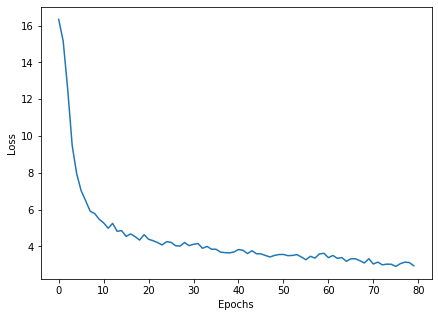

In [70]:
plt.figure(figsize=(7, 5))
plt.plot(loss_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()